In [14]:
import jax
import jax.numpy as jnp
import diffrax
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define the vector field for the ODE system
# y = [x, theta, v_x, omega]
# args = (L, g)
def rod_dynamics(t, y, args):
    x, theta, v_x, omega = y
    L, g = args

    cos_theta = jnp.cos(theta)
    sin_theta = jnp.sin(theta)
    denominator = 1.0 + 3.0 * cos_theta**2

    dx_dt = v_x
    dtheta_dt = omega
    dvx_dt = (cos_theta * (2.0 * L * omega**2 - 3.0 * g * sin_theta)) / denominator
    domega_dt = (3.0 * cos_theta * (L * omega**2 * sin_theta - 2.0 * g)) / (L * denominator)

    return jnp.array([dx_dt, dtheta_dt, dvx_dt, domega_dt])

def solve_rod_odes(L_param, g_param, y0_state, t_start, t_end, num_frames):
    """
    Solves the ODEs for the rod dynamics.
    """
    args_params = (L_param, g_param)
    dt0_initial = 0.01
    solver = diffrax.Tsit5()
    stepsize_controller = diffrax.PIDController(rtol=1e-7, atol=1e-9)
    saveat_strategy = diffrax.SaveAt(ts=jnp.linspace(t_start, t_end, num_frames))
    term_def = diffrax.ODETerm(rod_dynamics)

    print(f"Starting ODE solution with initial conditions:")
    print(f"  x0     = {y0_state[0]:.2f} m")
    print(f"  theta0 = {jnp.rad2deg(y0_state[1]):.2f} degrees")
    print(f"  vx0    = {y0_state[2]:.2f} m/s")
    print(f"  omega0 = {y0_state[3]:.2f} rad/s")
    print(f"Parameters: L = {L_param:.2f} m, g = {g_param:.2f} m/s^2")
    print(f"Time span: [{t_start:.1f}s, {t_end:.1f}s], Frames for animation: {num_frames}")

    solution_obj = diffrax.diffeqsolve(
        term_def,
        solver,
        t_start,
        t_end,
        dt0_initial,
        y0_state,
        args=args_params,
        saveat=saveat_strategy,
        stepsize_controller=stepsize_controller,
        max_steps=16**5
    )
    print(f"ODE solution completed. Number of steps taken by solver: {solution_obj.stats['num_steps']}")
    return solution_obj

def animate_rod_motion(solution, L_rod):
    """
    Creates and displays an animation of the rod's motion.
    """
    # Get times and positions from solution
    times = solution.ts
    x_contact_vals = solution.ys[:, 0]
    theta_vals = solution.ys[:, 1]

    # Setup the figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))

    # Calculate dynamic plot limits
    rod_end_x = x_contact_vals + L_rod * jnp.cos(theta_vals)
    rod_end_y = L_rod * jnp.sin(theta_vals)
    
    # Calculate plot limits including margins
    margin = 0.5 * L_rod
    min_x = jnp.min(jnp.concatenate([x_contact_vals, rod_end_x])) - margin
    max_x = jnp.max(jnp.concatenate([x_contact_vals, rod_end_x])) + margin
    min_y = min(0, float(jnp.min(rod_end_y))) - margin
    max_y = float(jnp.max(rod_end_y)) + margin
    
    # Setup axis properties
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("Horizontal position (m)")
    ax.set_ylabel("Vertical position (m)")
    ax.set_title("Rod Motion Animation")
    ax.grid(True)

    # Draw ground line
    ax.axhline(0, color='black', lw=2, label='Ground')

    # Initialize rod with first position
    x_init = x_contact_vals[0]
    theta_init = theta_vals[0]
    x_tip_init = x_init + L_rod * jnp.cos(theta_init)
    y_tip_init = L_rod * jnp.sin(theta_init)
    
    # Create artists with new variable names to avoid confusion
    rod_line, = ax.plot([x_init, x_tip_init], [0, y_tip_init],
                      color='blue', lw=3, marker='o', markersize=6, label='Rod')
    contact_point, = ax.plot([x_init], [0], 'go', markersize=8, label='Contact Point')
    
    # Time text display
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", fc="wheat", alpha=0.5))
    
    ax.legend(loc='upper right')

    def update_frame(frame):
        # Get current position data
        x_c = float(x_contact_vals[frame])  # Convert to Python float
        theta = float(theta_vals[frame])    # Convert to Python float
        
        # Calculate rod tip position
        x_tip = x_c + L_rod * jnp.cos(theta)
        y_tip = L_rod * jnp.sin(theta)
        
        # Update rod line
        rod_line.set_data([x_c, float(x_tip)], [0, float(y_tip)])
        # Update contact point
        contact_point.set_data([x_c], [0])
        # Update time text
        time_text.set_text(f'Time: {float(times[frame]):.2f} s\nAngle: {float(jnp.rad2deg(theta)):.1f}°')
        
        # Change color if rod goes through ground
        rod_line.set_color('purple' if theta < 0 else 'blue')
        
        # Return all artists that were modified
        return rod_line, contact_point, time_text

    # Create animation
    anim = animation.FuncAnimation(
        fig, 
        update_frame,
        frames=len(times),
        interval=50,  # 20 fps
        blit=True,
        repeat=False
    )
    
    plt.show()

def main():
    # Parameters for the simulation
    L_rod = 1.0      # Length of the rod (m)
    g_gravity = 9.81 # Acceleration due to gravity (m/s^2)
    
    # Initial conditions for the rod
    # Based on the user's image, rod is at an angle, touching ground, with some Vxo
    x0_pos = 0.0                # Initial horizontal position of the contact point (m)
    theta0_angle = jnp.pi / 6   # Initial angle (30 degrees)
    vx0_vel = 1.0               # Initial horizontal velocity (Vxo) (m/s)
    omega0_ang_vel = 0.5        # Initial angular velocity (rad/s) - let's give it a small spin
    
    initial_state = jnp.array([x0_pos, theta0_angle, vx0_vel, omega0_ang_vel])

    # Simulation time and number of frames for animation
    t_start_sim = 0.0
    t_end_sim = 7.0             # Simulate for 7 seconds
    desired_fps = 20
    num_frames = int(t_end_sim * desired_fps)  # This gives us 20fps for the animation

    # 1. Solve the ODEs
    rod_solution = solve_rod_odes(L_rod, g_gravity, initial_state,
                                t_start_sim, t_end_sim, num_frames)
    
    # 2. Animate the motion
    if rod_solution.ys is not None and len(rod_solution.ys) > 0:
        animate_rod_motion(rod_solution, L_rod)
    else:
        print("ODE solution did not produce valid results for animation.")


Starting ODE solution with initial conditions:
  x0     = 0.00 m
  theta0 = 30.00 degrees
  vx0    = 1.00 m/s
  omega0 = 0.50 rad/s
Parameters: L = 1.00 m, g = 9.81 m/s^2
Time span: [0.0s, 7.0s], Frames for animation: 140
ODE solution completed. Number of steps taken by solver: 466
ODE solution completed. Number of steps taken by solver: 466


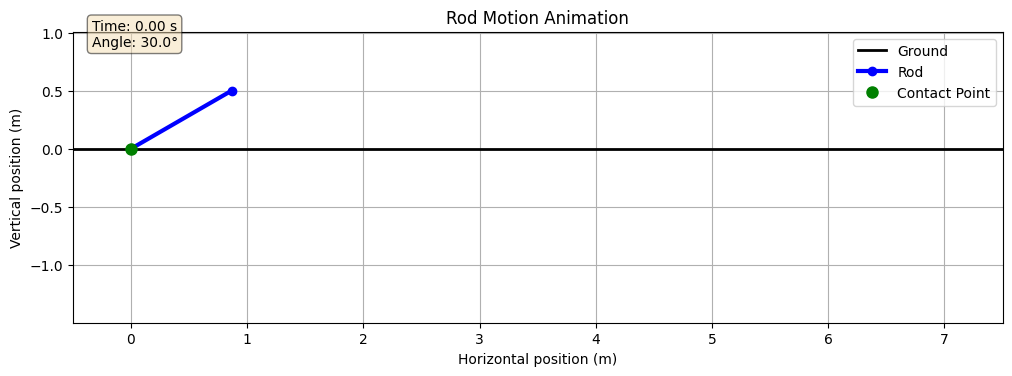

In [15]:
main()